#### **Post Processing Notebook for Anomaly Detection**

**Tech Preamble**

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from esn_dev import detrend
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

**Select Region**

In [4]:
region = "Kuro_new_2"

In [5]:
lon = np.load(f"Data/lon_{region}.npy")
lat = np.load(f"Data/lat_{region}.npy")

# time_space_int_scalar_error = np.load(f"/home/hmelzer/work/esn/CESM/{region}_anom/esn000/time_space_int_scalar_error.npy")
time_int_spat_error = np.load(f"/home/hmelzer/work/esn/CESM/{region}_anom/esn000/time_int_spat_error.npy")

Ntrain = 657

**Select Window Sizes**

In [6]:
# Define window configs
window_configs = [(1, 200), (2, 200), (3, 200), (5, 200)]  # Add as many as you need

# Define tags based on window configs
window_tags = { (sw, lw): f"sw_{sw}_lw_{lw}" for sw, lw in window_configs }

**Run Anomaly Detection (3D)**

In [7]:
from esn_dev.anomaly import *

In [8]:
anom_scores_3d = {}
lw_mus_3d = {}
lw_stds_3d = {}
sw_mus_3d = {}

for sw, lw in window_configs:
    tag = f"sw_{sw*5}_lw_{lw*5}"
    score, mu, std, smu = sliding_score(time_int_spat_error, sw, lw)
    anom_scores_3d[(sw, lw)] = score
    lw_mus_3d[(sw, lw)] = mu
    lw_stds_3d[(sw, lw)] = std
    sw_mus_3d[(sw, lw)] = smu
    window_tags[(sw, lw)] = tag  # Define tags ahead of time


In [9]:
# folder = "Post_Processing"

# for sw, lw in window_configs:
#     tag = window_tags[(sw, lw)]
    
#     np.save(f"{folder}/anom_score_3d_{tag}.npy", anom_scores_3d[(sw, lw)])
#     np.save(f"{folder}/lw_mu_3d_{tag}.npy", lw_mus_3d[(sw, lw)])
#     np.save(f"{folder}/lw_std_3d_{tag}.npy", lw_stds_3d[(sw, lw)])
#     np.save(f"{folder}/sw_mu_3d_{tag}.npy", sw_mus_3d[(sw, lw)])

**Plot**

In [10]:
from esn_dev.visualize_results_anom import *

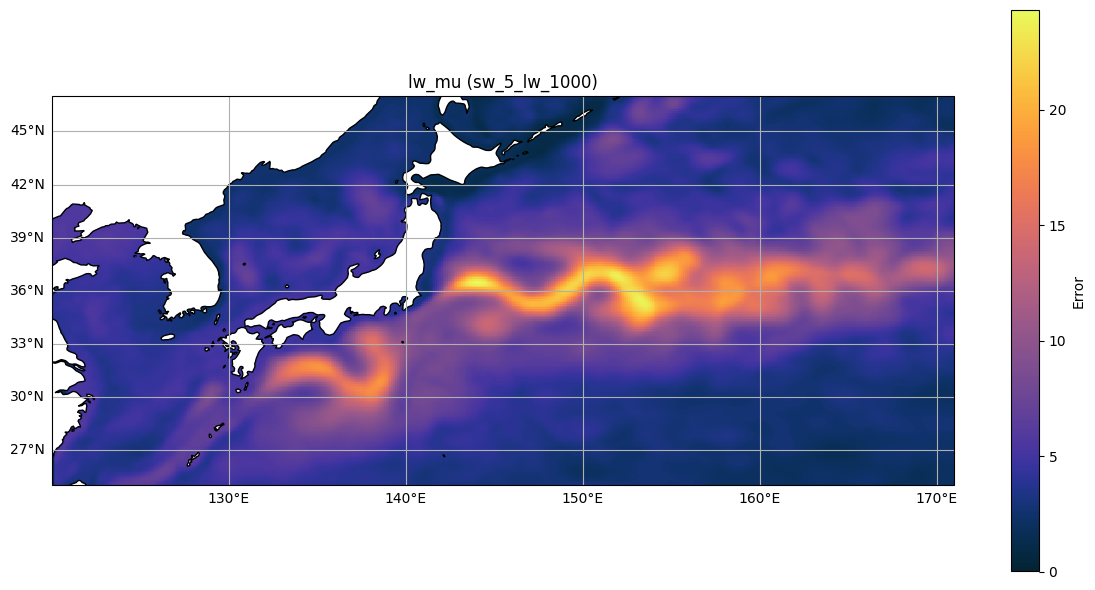

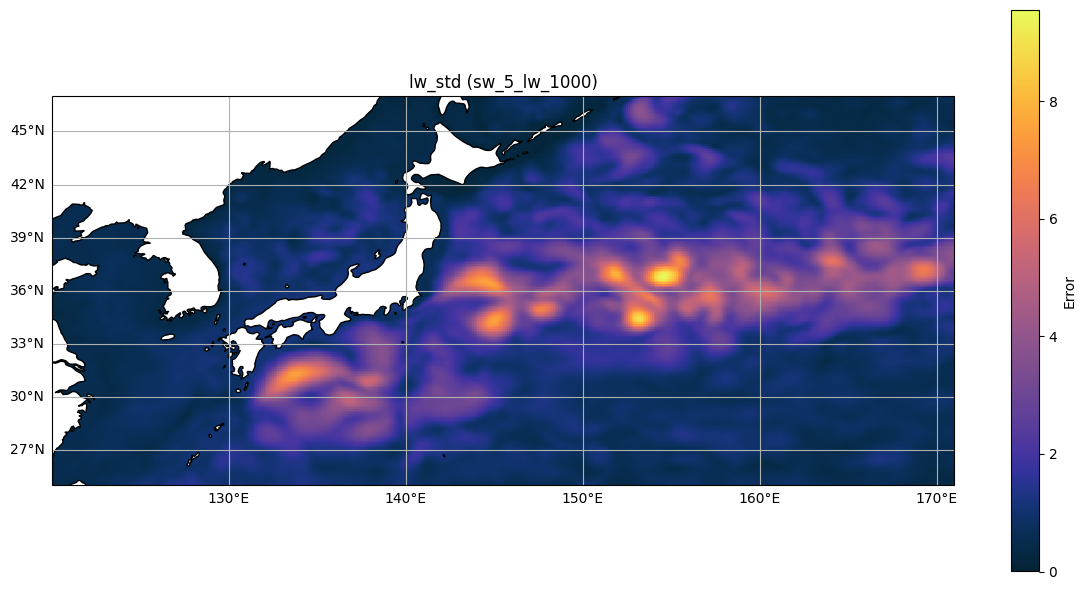

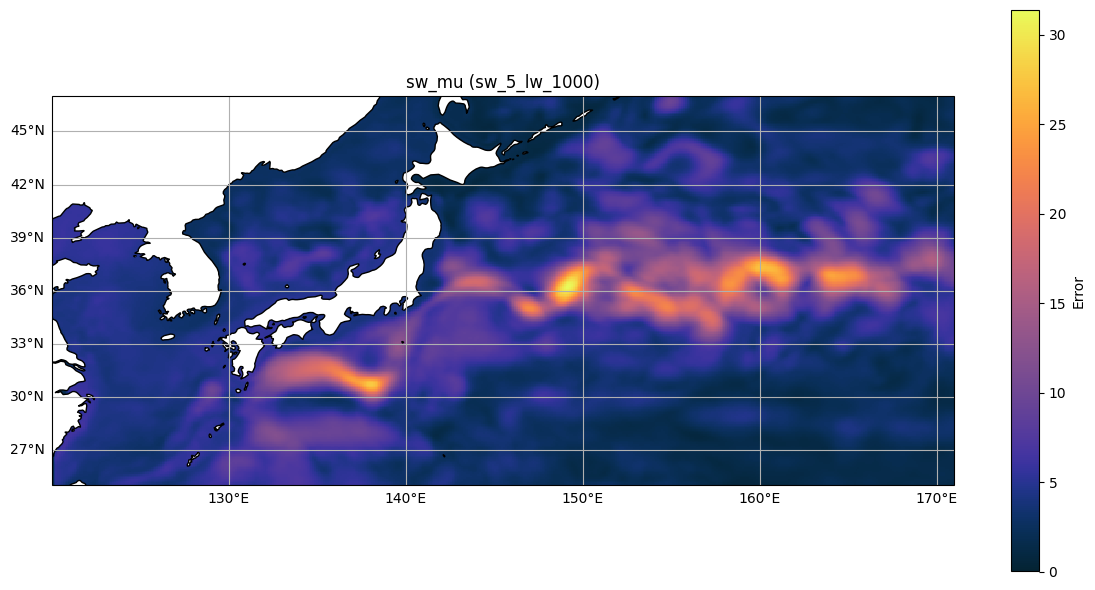

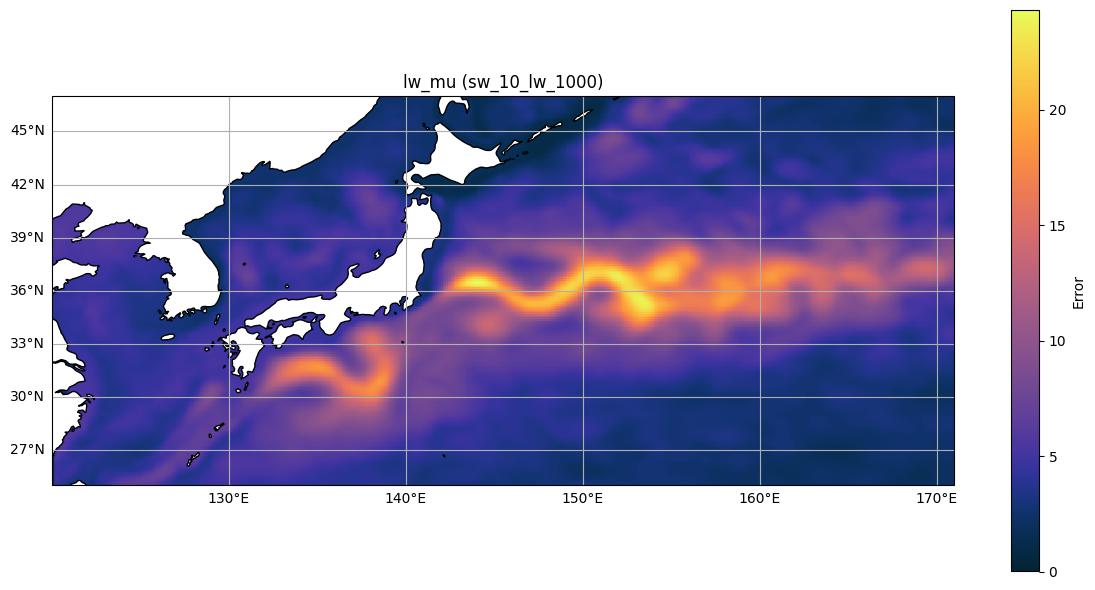

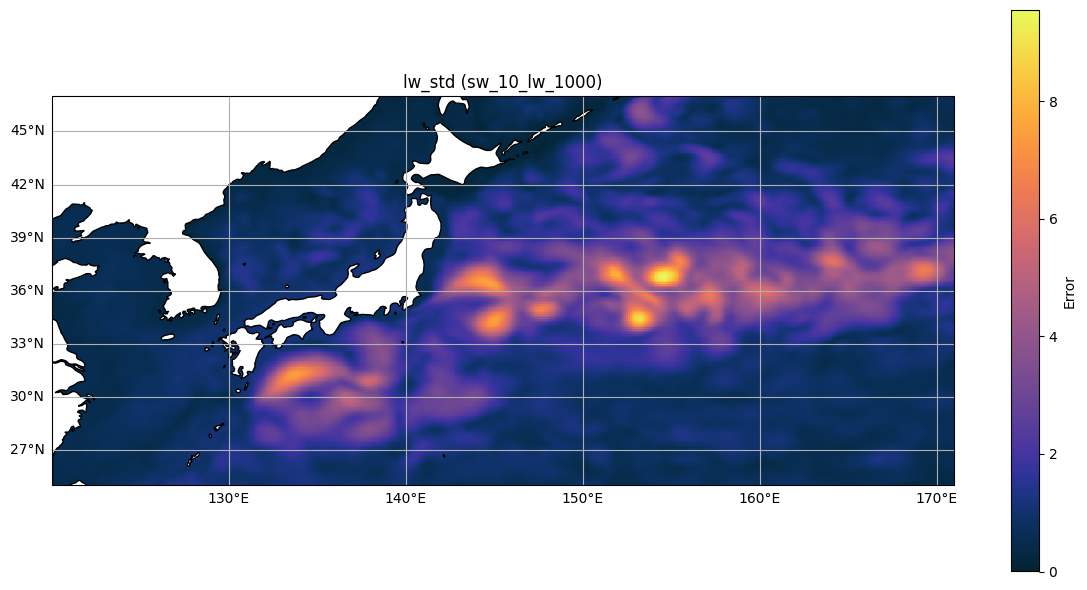

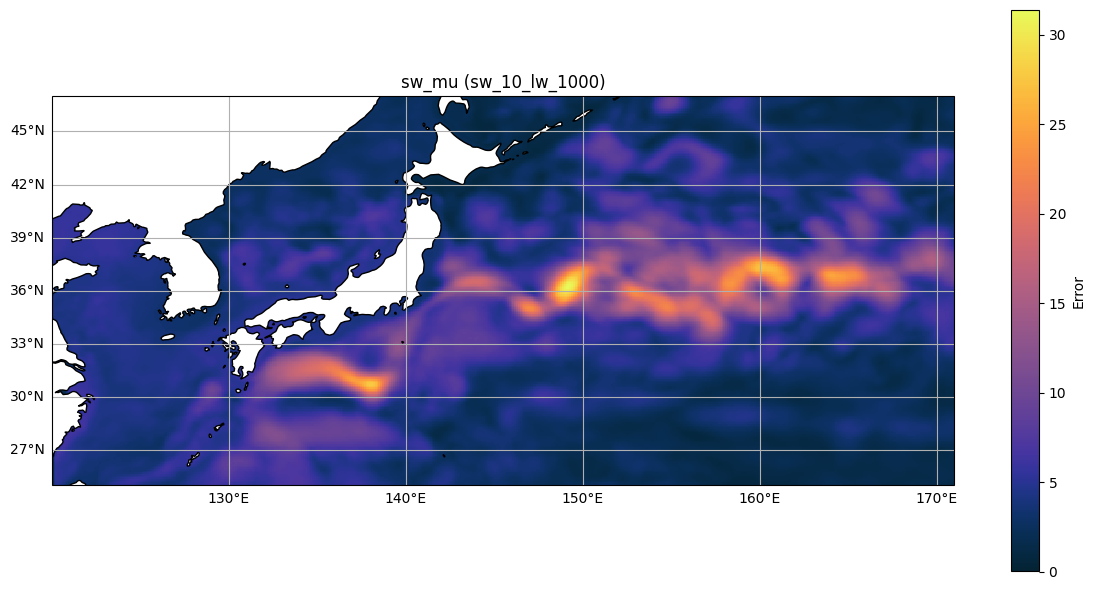

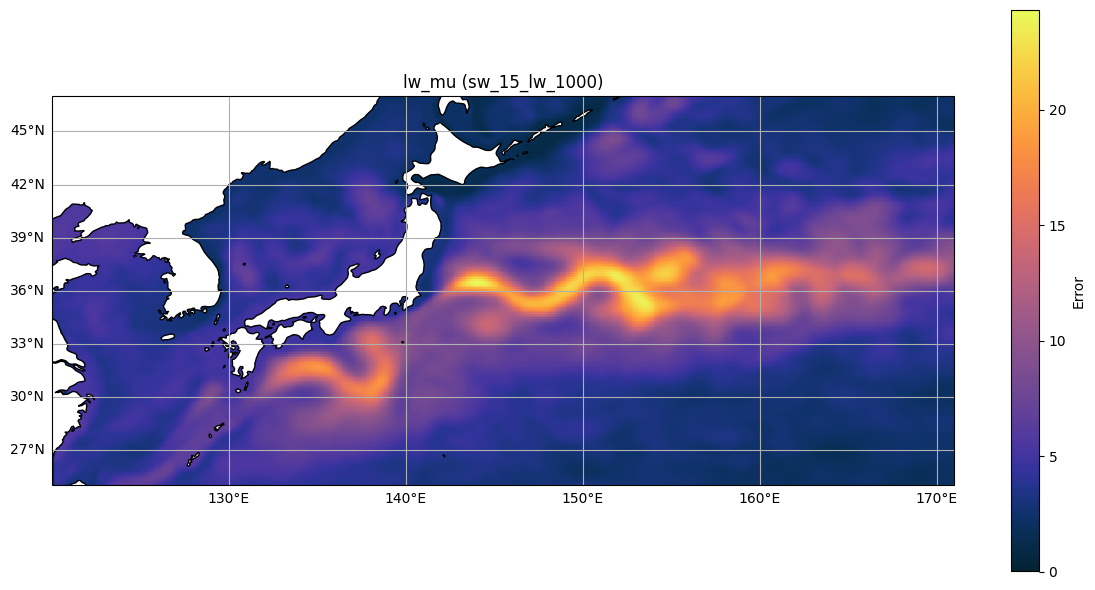

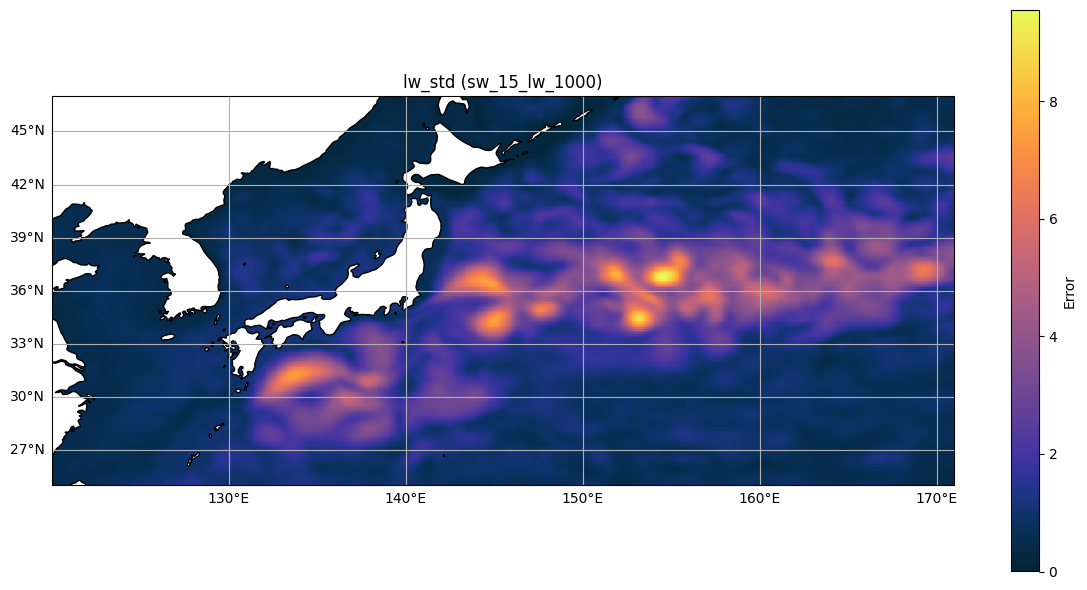

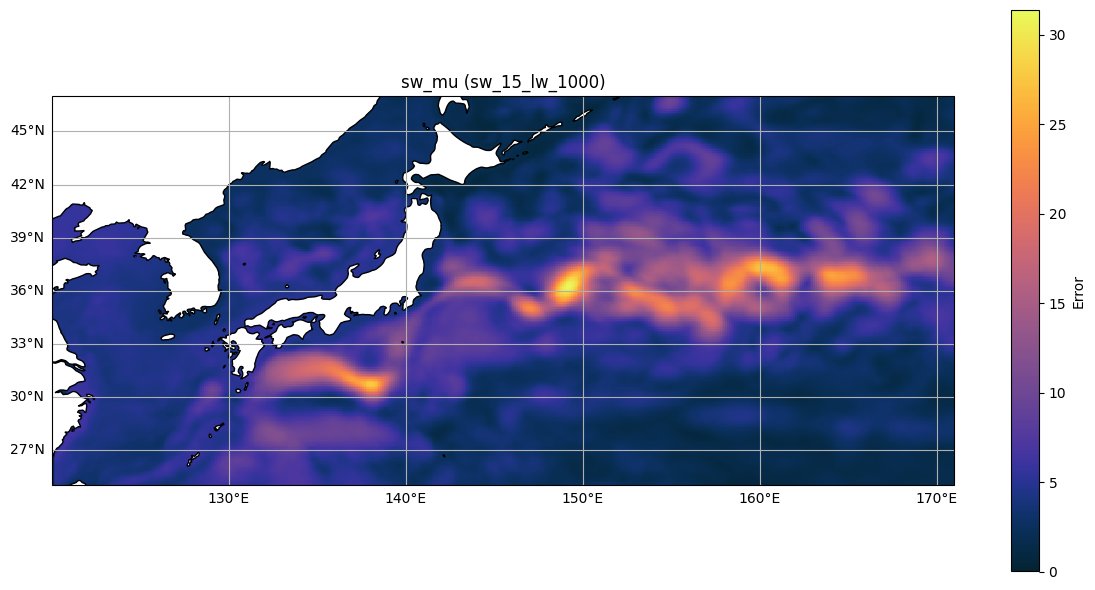

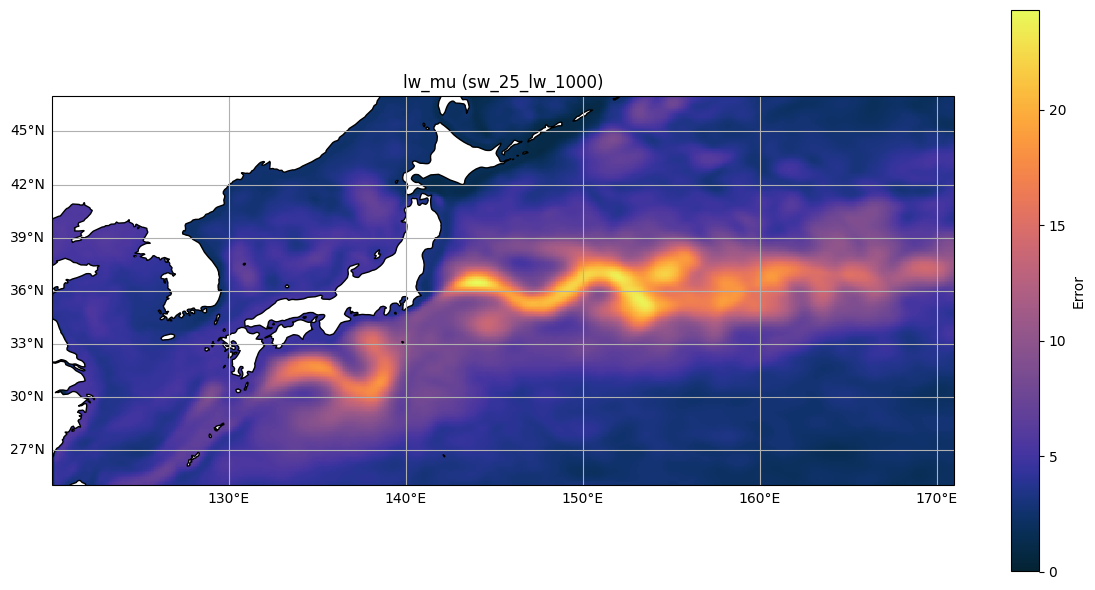

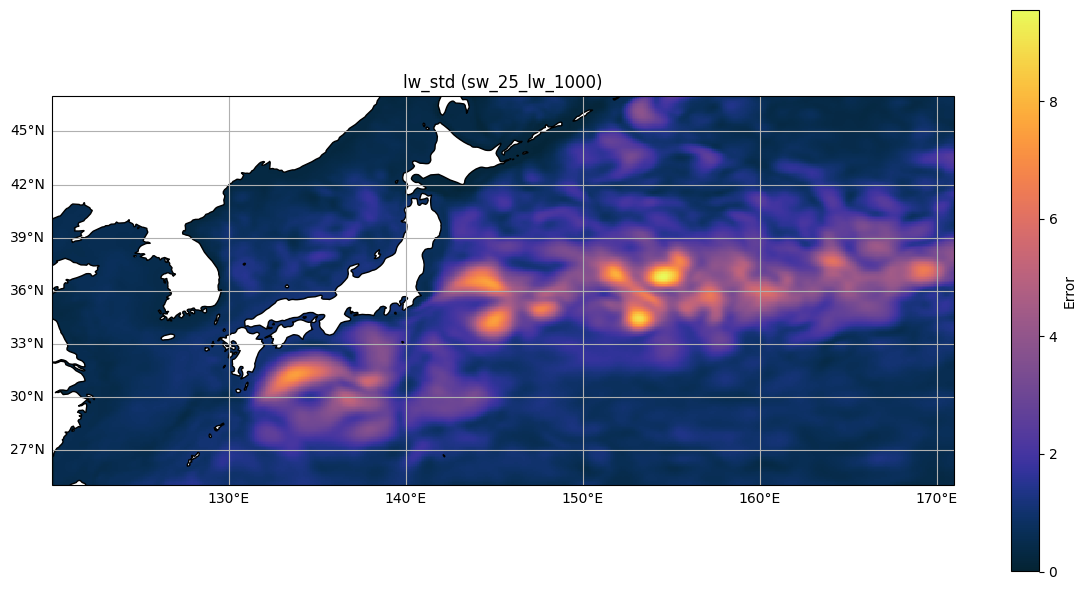

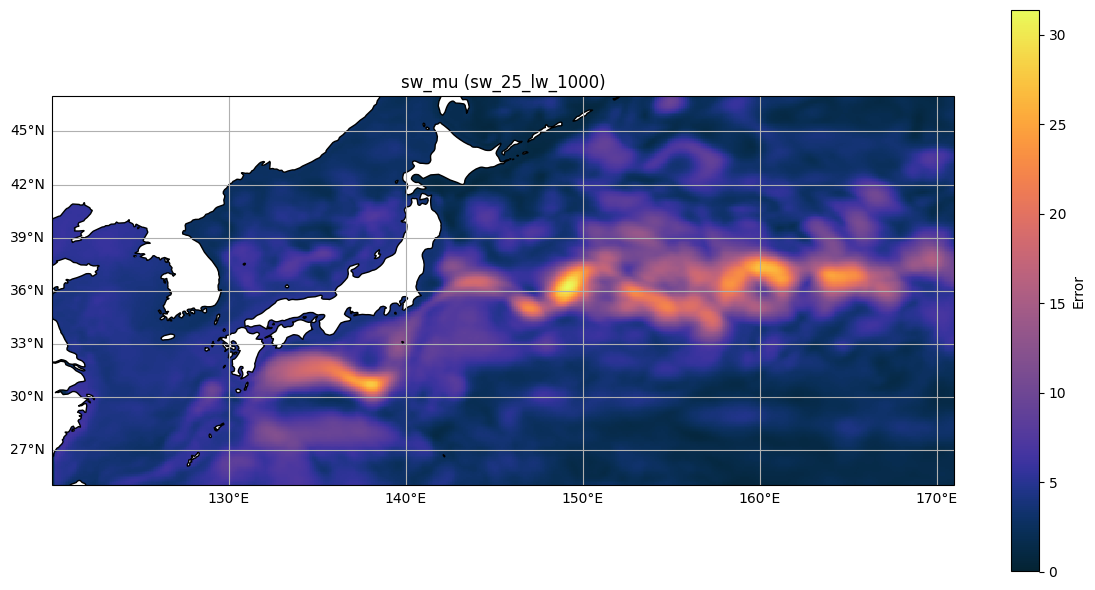

In [11]:
# Loop through keys in lw_mus_3d (same keys apply to the others)
for key in lw_mus_3d:
    tag = window_tags[key]

    # Extract the relevant fields
    mu = lw_mus_3d[key]
    std = lw_stds_3d[key]
    smu = sw_mus_3d[key]
    
    for field, name in zip([mu, std, smu], ['lw_mu', 'lw_std', 'sw_mu']):
        fig = plt.figure(figsize=(12, 6))
        ax = plt.axes(projection=ccrs.PlateCarree())

        # Plot the last time slice
        pcm = ax.pcolormesh(lon, lat, field[-1, :, :],
                            shading='auto',
                            cmap=cmocean.cm.thermal,
                            transform=ccrs.PlateCarree())

        # Add features
        ax.add_feature(cfeature.LAND, facecolor='white', zorder=1)
        ax.coastlines()
        ax.set_extent([lon.min() + 1, lon.max() - 1,
                       lat.min() + 1, lat.max() - 1], crs=ccrs.PlateCarree())

        # Gridlines
        gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
        gl.top_labels = False
        gl.right_labels = False

        # Colorbar and title
        plt.colorbar(pcm, ax=ax, orientation='vertical', label='Error')
        ax.set_title(f"{name} ({tag})")

        # Save the figure
        plt.tight_layout()
        plt.savefig(f"figures/{name}_{tag}.png", dpi=300)
        plt.show()


**Select Subregion to perform Anomaly Detection on**

In [12]:
lon_min, lon_max = 130, 140
lat_min, lat_max = 28, 35

region_tag = "reg_1"

In [13]:
lon_1d = lon[0, :] 
lat_1d = lat[:, 0] 

lon_idx = np.where((lon_1d >= lon_min) & (lon_1d <= lon_max))[0]
lat_idx = np.where((lat_1d >= lat_min) & (lat_1d <= lat_max))[0]

time_int_spat_error_og = time_int_spat_error.copy()

time_int_spat_error = time_int_spat_error_og[:, lat_idx[:, None], lon_idx]
time_space_int_scalar_error = time_int_spat_error.sum(axis=(1,2))

lon = lon[np.ix_(lat_idx, lon_idx)]
lat = lat[np.ix_(lat_idx, lon_idx)]

In [14]:
anom_scores = {}
lw_mus = {}
lw_stds = {}
sw_mus = {}

for sw, lw in window_configs:
    tag = f"sw_{sw*5}_lw_{lw*5}"
    score, mu, std, smu = sliding_score(time_space_int_scalar_error, sw, lw)
    anom_scores[(sw, lw)] = score
    lw_mus[(sw, lw)] = mu
    lw_stds[(sw, lw)] = std
    sw_mus[(sw, lw)] = smu
    window_tags[(sw, lw)] = tag  # Define tags ahead of time

In [15]:
# folder = "Post_Processing"

# for sw, lw in window_configs:
#     tag = window_tags[(sw, lw)]
#     np.save(f"{folder}/anom_score_{tag}.npy", anom_scores[(sw, lw)])
#     np.save(f"{folder}/lw_mu_{tag}.npy", lw_mus[(sw, lw)])
#     np.save(f"{folder}/lw_std_{tag}.npy", lw_stds[(sw, lw)])
#     np.save(f"{folder}/sw_mu_{tag}.npy", sw_mus[(sw, lw)])

**Plot**

In [16]:
# for sw, lw in window_configs:
#     tag = window_tags[(sw, lw)]
#     fig = time_space_int_scalar_error_lw_sw_plot(
#         time_space_int_scalar_error,
#         lw_mus[(sw, lw)],
#         sw_mus[(sw, lw)],
#         lw_stds[(sw, lw)],
#         lon,
#         Ntrain,
#         subplot_kw=None,
#         title=f"Normalized Error Metrics {region_tag} ({tag})"
#     )
#     fig.savefig(f"figures/time_space_int_scalar_error_lw_sw_plot_{region_tag}_{tag}.png", dpi=300, bbox_inches="tight")


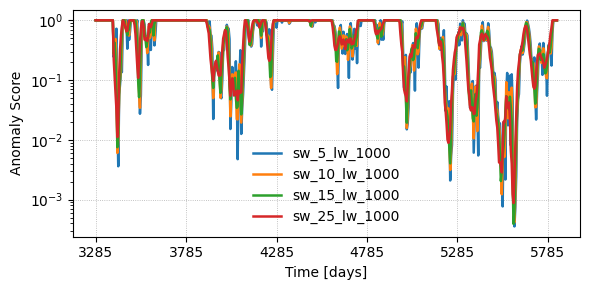

In [17]:
all_scores = [anom_scores[(sw, lw)] for sw, lw in window_configs]

fig = anom_score_plot(all_scores, Ntrain, window_configs)

# Create a concise, descriptive suffix using the window sizes
window_suffix = "_".join([f"sw{sw*5}_lw{lw*5}" for sw, lw in window_configs])

# Save with the descriptive suffix
fig.savefig(f"figures/anom_score_all_{region_tag}_{window_suffix}.png", dpi=300, bbox_inches="tight")

In [28]:
threshold = 10e-2

# Dictionary to hold indices for each (sw, lw) config
high_score_indices = {}

for sw, lw in window_configs:
    scores = anom_scores[(sw, lw)]
    indices = np.where(scores <= threshold)[0]
    high_score_indices[(sw, lw)] = indices

# Example: print indices for each config
for config, indices in high_score_indices.items():
    print(f"Config {config}: Indices with score <= 1e-2 -> {indices}")


Config (1, 200): Indices with score <= 1e-2 -> [ 24  25  26  27  49  50 130 138 139 140 149 150 152 153 154 156 157 158
 161 162 163 194 195 268 341 344 345 346 353 387 388 389 390 391 392 393
 394 395 413 414 415 416 417 418 419 420 421 422 423 443 444 445 446 447
 448 449 450 451 452 453 454 456 457 459 461 462 463 464 465 466 467 468
 486 487 488 499]
Config (2, 200): Indices with score <= 1e-2 -> [ 24  25  26  48  49 130 138 139 149 150 152 153 156 157 158 160 161 162
 163 194 343 344 345 346 386 387 388 389 390 391 392 393 394 395 413 414
 415 416 417 418 419 420 421 422 423 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 486
 487 488]
Config (3, 200): Indices with score <= 1e-2 -> [ 23  24  25  26  47  48  49 130 137 138 148 149 150 152 155 156 157 159
 160 161 162 343 344 345 346 386 387 388 389 390 391 392 393 394 412 413
 414 415 416 417 418 419 420 421 422 423 441 442 443 444 445 446 447 448
 449 450 451 452 453 454 455

In [32]:
high_score_indices[(1, 200)]

array([ 24,  25,  26,  27,  49,  50, 130, 138, 139, 140, 149, 150, 152,
       153, 154, 156, 157, 158, 161, 162, 163, 194, 195, 268, 341, 344,
       345, 346, 353, 387, 388, 389, 390, 391, 392, 393, 394, 395, 413,
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 443, 444, 445,
       446, 447, 448, 449, 450, 451, 452, 453, 454, 456, 457, 459, 461,
       462, 463, 464, 465, 466, 467, 468, 486, 487, 488, 499])